## 1. Dataset Preparation and Preprocessing:


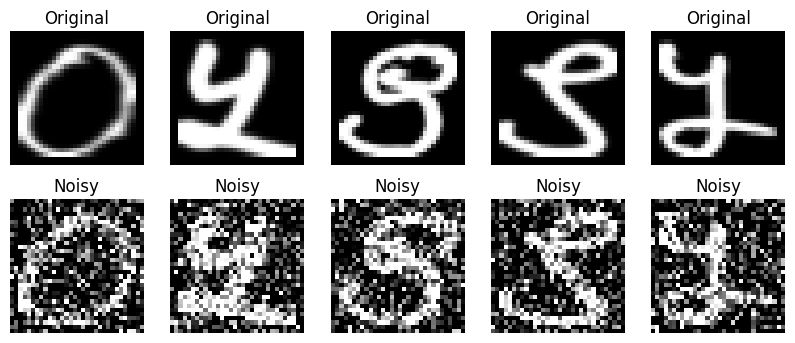

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def load_devnagari_dataset(dataset_path, img_size=(32, 32)):
    images = []
    labels = []
    label_mapping = {}
    current_label = 0

    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)
        if os.path.isdir(folder_path):
            if folder_name not in label_mapping:
                label_mapping[folder_name] = current_label
                current_label += 1

            numeric_label = label_mapping[folder_name]

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                try:
                    img = Image.open(img_path)
                    img = img.resize(img_size)
                    images.append(np.array(img))
                    labels.append(numeric_label)
                except Exception as e:
                    print(f"Failed to process image {img_path}: {e}")

    return np.array(images), np.array(labels)

dataset_path = "/content/drive/MyDrive/AI and ML/Week 4/DevanagariHandwrittenDigitDataset/Train"
images, labels = load_devnagari_dataset(dataset_path)

images = images.astype('float32') / 255.0
images = np.reshape(images, (images.shape[0], 32, 32, 1))

x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

def add_gaussian_noise(images, noise_factor=0.5):
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    return noisy_images

x_train_noisy = add_gaussian_noise(x_train, noise_factor=0.5)
x_val_noisy = add_gaussian_noise(x_val, noise_factor=0.5)

import matplotlib.pyplot as plt

def visualize_images(original, noisy, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')
    plt.show()

visualize_images(x_train, x_train_noisy, n=5)

# 2. Build the Denoising Convolutional Autoencoder:


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_shape=(32, 32, 1)):
    # Encoder
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

# 3. Train the Denoising Autoencoder:

In [6]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_val_noisy, x_val)
)


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 83s 780ms/step - loss: 0.2887 - val_loss: 0.2308
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 131s 675ms/step - loss: 0.2129 - val_loss: 0.1921
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 678ms/step - loss: 0.1891 - val_loss: 0.1798
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 677ms/step - loss: 0.1783 - val_loss: 0.1715
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 662ms/step - loss: 0.1704 - val_loss: 0.1676
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 658ms/step - loss: 0.1649 - val_loss: 0.1623
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 71s 660ms/step - loss: 0.1618 - val_loss: 0.1604
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 81s 646ms/step - loss: 0.1584 - val_loss: 0.1584
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 653ms/step - loss: 0.1560 - val_loss: 0.1560
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 86s 695ms/step - loss: 0.1542 - val_loss: 0.1539
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 70s 651ms/step - loss: 0.1520 - val_loss: 0.1532
Epoch 12/50
107/10

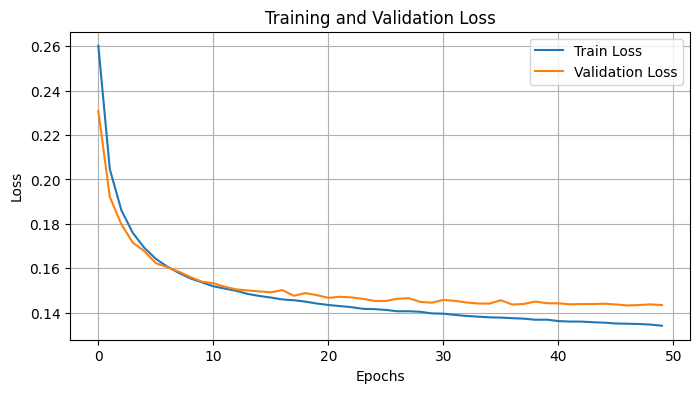

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# 4. Evaluate and Visualize the Results

107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step


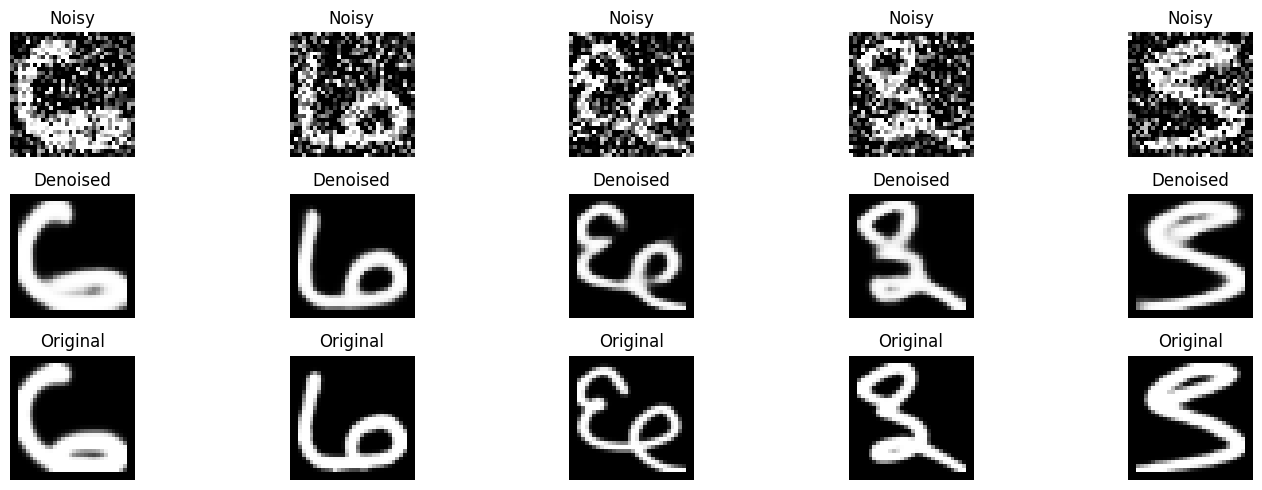

In [8]:
# Predict on noisy validation images
denoised_images = autoencoder.predict(x_val_noisy)

# Function to display noisy, denoised, and original images
def display_denoised_results(noisy_imgs, denoised_imgs, original_imgs, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Noisy image
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_imgs[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised image
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_imgs[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Original image
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(original_imgs[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_denoised_results(x_val_noisy, denoised_images, x_val)
